# Housing Price Prediction using Advanced Regression Techniques

## Introduction

This project tackles the classic supervised learning problem of predicting house sale prices using structured tabular data. The dataset is sourced from the [Kaggle House Prices – Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition. It contains 79 explanatory variables (both categorical and numerical) that describe various aspects of residential homes in Ames, Iowa.

Our goal is to build a robust regression model that can accurately predict the `SalePrice` of a house based on these features.


## Dataset Description
The dataset contains:

- Train set: 1460 entries with 81 features + SalePrice
- Test set: 1459 entries without SalePrice
- Target: SalePrice (continuous)

### Importing required libraries

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

### Load Datasets
The dataset contains detailed information about residential houses. We begin by reading the train and test CSV files and concatenating them to ensure uniform preprocessing.

In [33]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train_len = train.shape[0]
print("Full train dataset shape is {}".format(train.shape))
test["SalePrice"] = np.nan

Full train dataset shape is (1460, 81)


In [34]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Combine train and test dataset

In [35]:
full = pd.concat([train, test], ignore_index=True)

### Drop Irrelevant Columns

In [36]:
full.drop(columns=["Id"], inplace=True)
full.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [37]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [38]:
full.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0
BsmtFinSF2,2918.0,49.582248,169.205611,0.0,0.0,0.0,0.0,1526.0


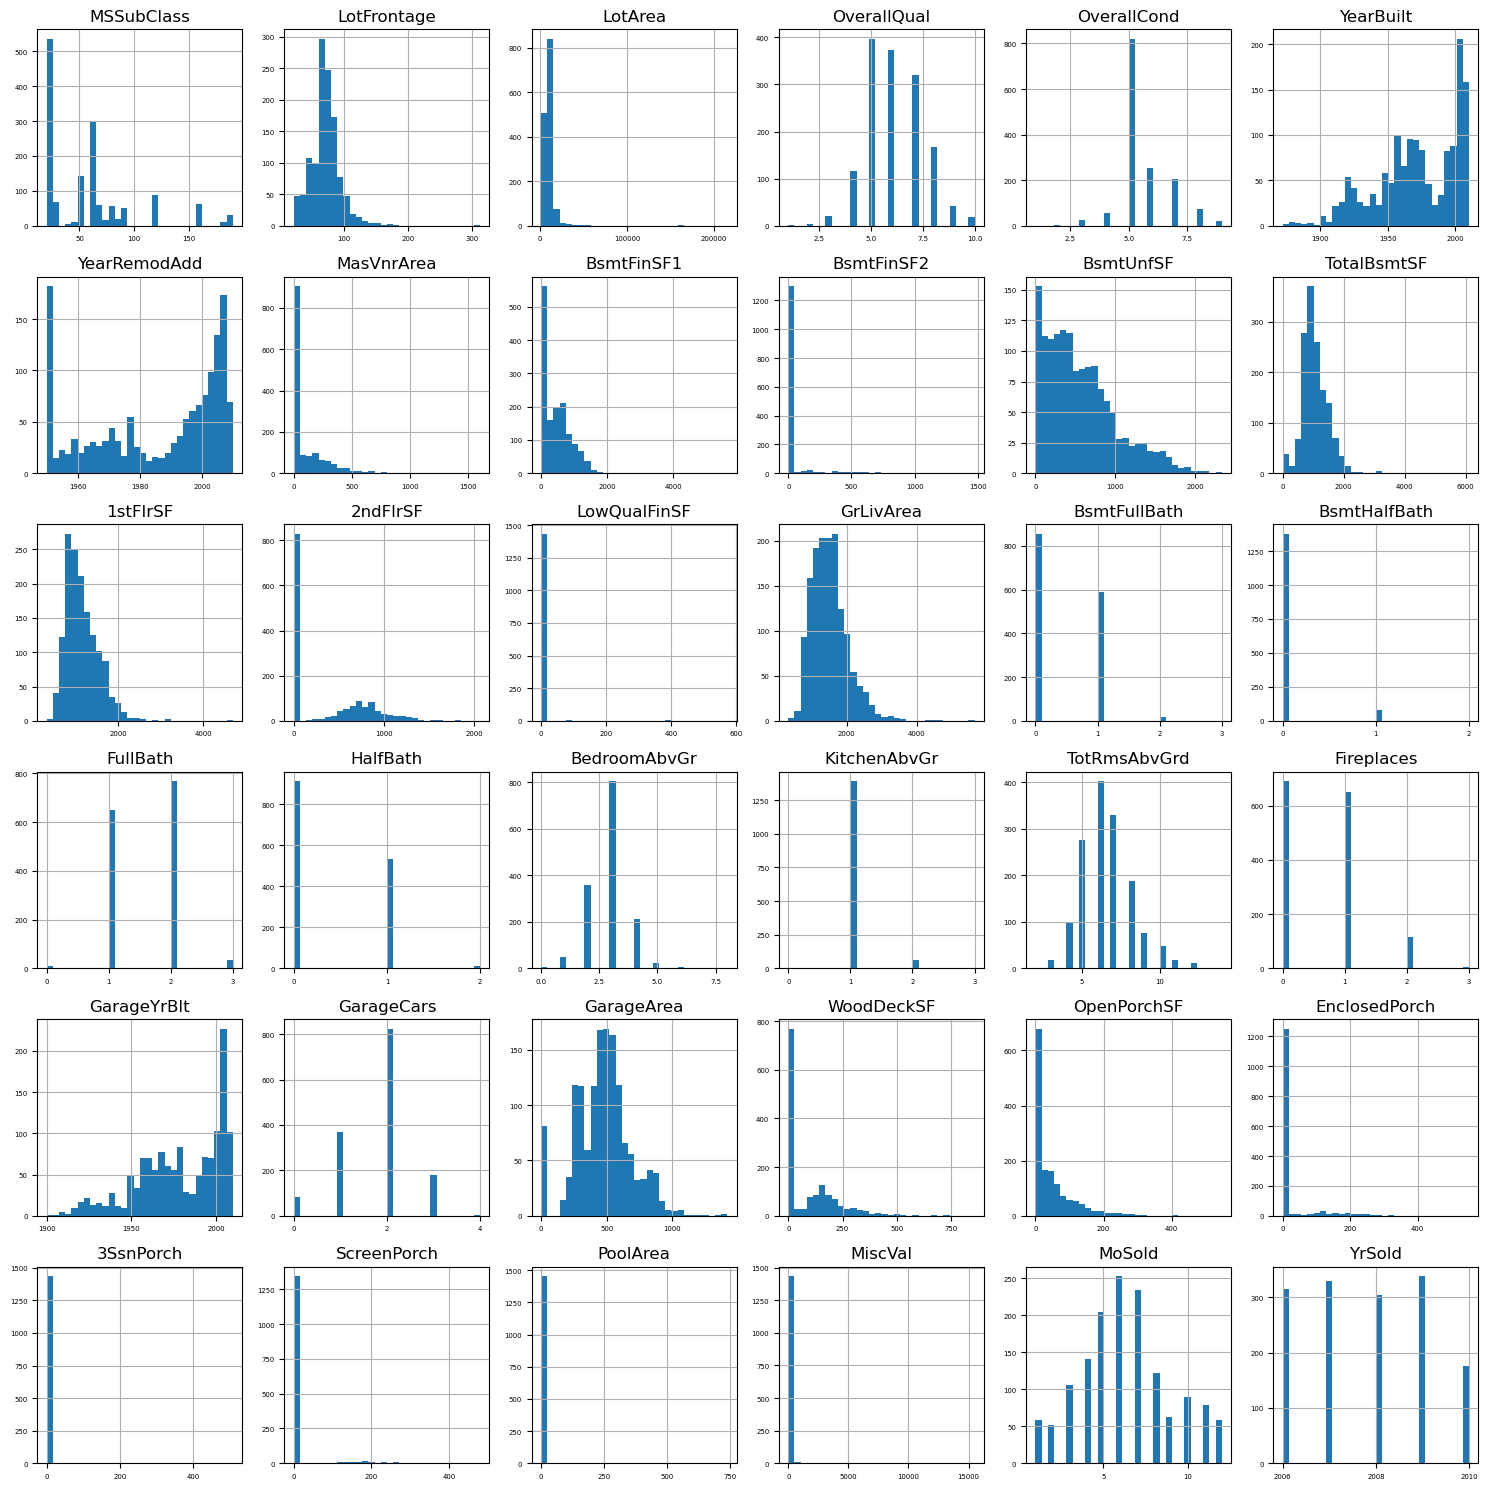

In [39]:
full_train = full[~full['SalePrice'].isnull()]

full_train.drop('SalePrice', axis=1).hist(figsize=(15, 15), xlabelsize=5, ylabelsize=5, bins=30)
plt.tight_layout()
plt.show()

### Missing values to be handled

In [40]:
full.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageCond       159
GarageYrBlt      159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
dtype: int64

### Handle missing values (using domain logic)
Missing data is treated using domain knowledge. This includes:
- Filling `None` for features where missing implies absence (e.g., no garage, no pool)
- Filling 0 for numerical features where missing means no area or count
- Filling mode for categorical and median for numerical values when appropriate

In [41]:
na_none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
                'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                'MasVnrType']
for col in na_none_cols:
    full[col] = full[col].fillna("None")

na_zero_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars',
                'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'MasVnrArea']
for col in na_zero_cols:
    full[col] = full[col].fillna(0)

In [42]:
for col in full.columns:
    if full[col].isna().sum() > 0:
        if full[col].dtype == "object":
            full[col] = full[col].fillna(full[col].mode()[0])
        else:
            full[col] = full[col].fillna(full[col].median())

In [43]:
full.isnull().sum().sort_values(ascending=False).head(20)

MSSubClass      0
MSZoning        0
GarageYrBlt     0
GarageType      0
FireplaceQu     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
BedroomAbvGr    0
HalfBath        0
FullBath        0
BsmtHalfBath    0
BsmtFullBath    0
GrLivArea       0
LowQualFinSF    0
2ndFlrSF        0
1stFlrSF        0
GarageFinish    0
dtype: int64

### Feature Engineering
New features are created to enhance the model’s ability to learn:
- `TotalSF`: Total square footage including basement and floors
- `TotalBathrooms`: Weighted sum of full and half baths
- `Age`: Age of the property at time of sale
- Binary indicators like `HasGarage`, `HasFireplace`, `HasPool`, etc.

In [44]:
full['TotalSF'] = full['TotalBsmtSF'] + full['1stFlrSF'] + full['2ndFlrSF']
full['TotalBathrooms'] = (full['FullBath'] + 0.5 * full['HalfBath'] +
                          full['BsmtFullBath'] + 0.5 * full['BsmtHalfBath'])
full['Age'] = full['YrSold'] - full['YearBuilt']
full['RemodAge'] = full['YrSold'] - full['YearRemodAdd']
full['HasPool'] = (full['PoolArea'] > 0).astype(int)
full['HasGarage'] = (full['GarageArea'] > 0).astype(int)
full['HasFireplace'] = (full['Fireplaces'] > 0).astype(int)
full['HasBsmt'] = (full['TotalBsmtSF'] > 0).astype(int)
cols = ['TotalSF', 'TotalBathrooms', 'Age', 'RemodAge', 
                   'HasPool', 'HasGarage', 'HasFireplace', 'HasBsmt']
display(full[cols].head())

,TotalSF,TotalBathrooms,Age,RemodAge,HasPool,HasGarage,HasFireplace,HasBsmt
0,2566.0,3.5,5,5,0,1,0,1
1,2524.0,2.5,31,31,0,1,1,1
2,2706.0,3.5,7,6,0,1,1,1
3,2473.0,2.0,91,36,0,1,1,1
4,3343.0,3.5,8,8,0,1,1,1


### Ordinal and Label Encoding
- Ordinal encoding is applied to quality-related features with a meaningful rank (e.g., `Ex`, `Gd`, `TA`, `Fa`, `Po`)
- Label encoding is applied to remaining categorical columns for use with tree-based models

In [45]:
qual_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
for col in ['ExterQual', 'KitchenQual', 'FireplaceQu', 'BsmtQual', 'BsmtCond', 
            'GarageQual', 'GarageCond', 'HeatingQC']:
    full[col] = full[col].map(qual_map)
ordinal_cols = ['ExterQual', 'KitchenQual', 'FireplaceQu', 'BsmtQual', 
                'BsmtCond', 'GarageQual', 'GarageCond', 'HeatingQC']
display(full[ordinal_cols].head())

,ExterQual,KitchenQual,FireplaceQu,BsmtQual,BsmtCond,GarageQual,GarageCond,HeatingQC
0,4,4,0,4,3,3,3,5
1,3,3,3,4,3,3,3,5
2,4,4,3,4,3,3,3,5
3,3,4,4,3,4,3,3,4
4,4,4,3,4,3,3,3,5


In [46]:
label_cols = full.select_dtypes(include='object').columns
le = LabelEncoder()
for col in label_cols:
    full[col] = le.fit_transform(full[col])
display(full[label_cols[:8]].head())

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope
0,3,1,1,3,3,0,4,0
1,3,1,1,3,3,0,2,0
2,3,1,1,0,3,0,4,0
3,3,1,1,0,3,0,0,0
4,3,1,1,0,3,0,2,0


### Dataset Preparation for Modeling
After preprocessing and feature engineering, we split the full dataset back into training and test sets, ready for model training and prediction.

In [47]:
processed_train = full.iloc[:train_len, :]
processed_test = full.iloc[train_len:, :].drop("SalePrice", axis=1)

processed_train.to_csv("processed_train.csv", index=False)
processed_test.to_csv("processed_test.csv", index=False)

### Model Training Preparation

We begin the modeling process by:
- Loading the preprocessed train and test datasets.
- Separating the target variable (`SalePrice`) from the feature set.
- Applying a logarithmic transformation to the target variable to align with the competition's RMSE log evaluation metric.
- Splitting the data into training and validation sets for model evaluation.
- Converting the datasets into LightGBM's optimized `Dataset` format.

In [48]:
train = pd.read_csv("processed_train.csv")
test = pd.read_csv("processed_test.csv")

In [49]:
original_test = pd.read_csv("test.csv")
test_ids = original_test["Id"]

In [50]:
X = train.drop("SalePrice", axis=1)
y = train["SalePrice"]
X_test = test.copy()

In [51]:
y_log = np.log1p(y)

In [52]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [53]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

Text(0.5, 1.0, 'Top 20 Important Features')

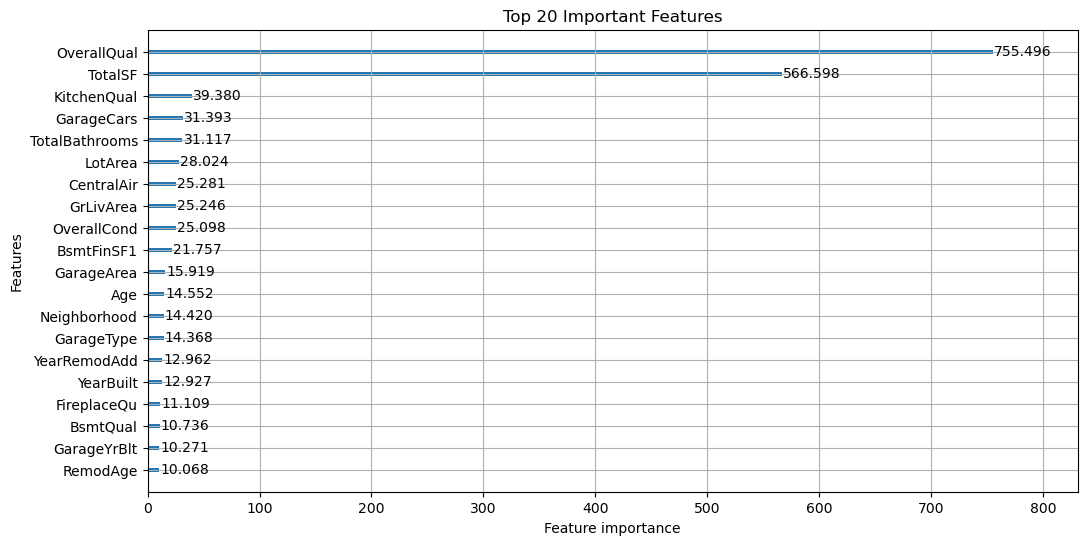

In [54]:
lgb.plot_importance(model, max_num_features=20, importance_type='gain', figsize=(12,6))
plt.title("Top 20 Important Features")

### Model Building: LightGBM
We use LightGBM for its efficiency and superior performance with structured data. The model is trained on the log-transformed target variable to minimize the Root Mean Squared Log Error (RMSLE).

In [55]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "verbose": -1
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=1000,
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.0661604	valid_1's rmse: 0.13883
[200]	training's rmse: 0.0428375	valid_1's rmse: 0.137303
Early stopping, best iteration is:
[169]	training's rmse: 0.0483761	valid_1's rmse: 0.137037


### Cross-Validation

To ensure generalizability and stability of our model, we use 5-Fold Cross-Validation.

In [56]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

for train_index, val_index in kf.split(X):
    X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = LGBMRegressor(
        objective='regression',
        metric='rmse',
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model_cv.fit(
    X_train_cv, y_train_cv,
    eval_set=[(X_val_cv, y_val_cv)],
    eval_metric="rmse"
    )


    preds_cv = model_cv.predict(X_val_cv)
    rmse = mean_squared_error(np.log1p(y_val_cv), np.log1p(preds_cv), squared=False)
    rmse_scores.append(rmse)

print("Average CV RMSE:", np.mean(rmse_scores))

Average CV RMSE: 0.13543098251072688


In [57]:
y_pred = model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f"Validation RMSE (log scale): {rmse:.4f}")

Validation RMSE (log scale): 0.1370


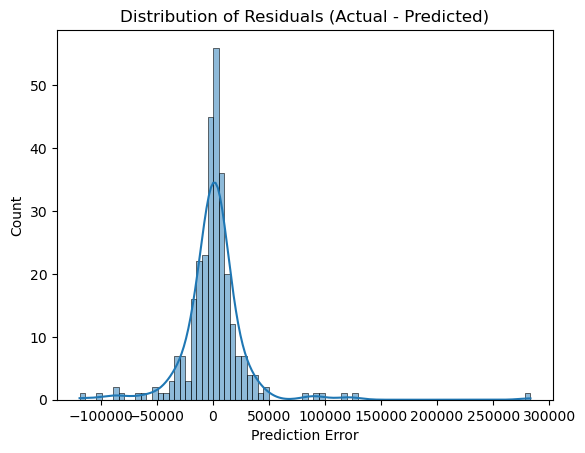

In [58]:
residuals = np.expm1(y_valid) - np.expm1(y_pred)

sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals (Actual - Predicted)")
plt.xlabel("Prediction Error")
plt.show()

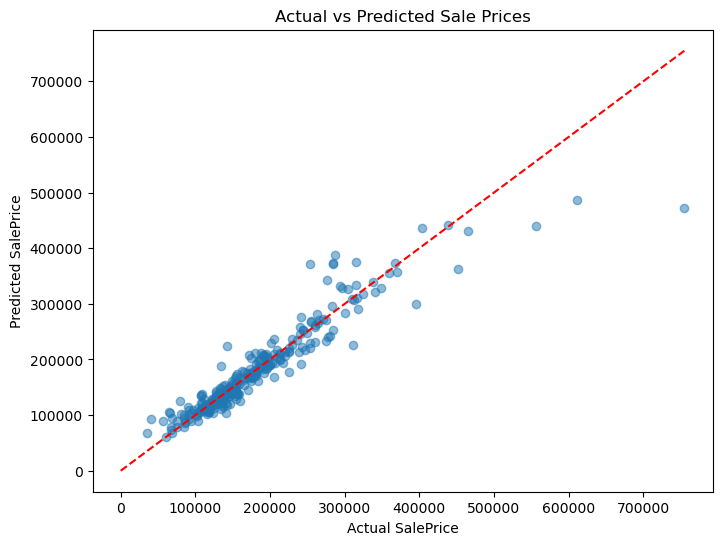

In [59]:
plt.figure(figsize=(8, 6))
plt.scatter(np.expm1(y_valid), np.expm1(y_pred), alpha=0.5)
plt.plot([0, max(np.expm1(y_valid))], [0, max(np.expm1(y_valid))], 'r--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted Sale Prices")
plt.show()

### Final Prediction & Submission File
The model is used to make predictions on the test dataset. These predictions are then inverse-log-transformed to get actual house prices. The final output is formatted as required by the competition and saved for submission.

In [60]:
test_preds = model.predict(X_test)
test_preds_final = np.expm1(test_preds)

submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": test_preds_final
})

submission.to_csv("submission.csv", index=False)
print("\nSubmission file saved!")
submission.head(10)


Submission file saved!


,Id,SalePrice
0,1461,126142.650126
1,1462,172459.745430
2,1463,180395.236430
3,1464,187851.968146
4,1465,182397.789367
5,1466,177499.800600
6,1467,178427.518497
7,1468,174176.091641
8,1469,180188.338755
9,1470,118899.934066


### Final Summary

- Built a complete pipeline for house price prediction using advanced regression techniques.
- Cleaned and engineered meaningful features based on domain understanding.
- Handled various data types using appropriate encoding strategies.
- Trained a LightGBM model with proper evaluation using cross-validation.
- Prepared the submission file with final predictions.

This notebook presents a complete and scalable approach to structured regression problems.